# Historical Structures Classification

## Problem Statement

There are hundreds of years-old historical structures that preserve a country's and 
community's history for future generations and promote tourism opportunities. 

To help the travel and tourism industries, it has been decided to use advanced machine 
learning techniques to monitor the condition of these historical structures and report to 
government agencies if any of them need maintenance. 

Also, understanding customers (tourists) and their expectations is critical for effective 
marketing. A recommendation engine is an excellent way to supplement existing 
marketing outreach to prospects.

## Part 1

XYZ Pvt. Ltd., a leading industry consulting firm, has been hired to help the cause by 
developing an intelligent and automated AI model using TensorFlow that can predict the 
category of a structure in an image.

### 1. Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["GRPC_VERBOSITY"] = "ERROR"
# os.environ["GLOG_minloglevel"] = "3"

# tf.get_logger().setLevel('ERROR')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

2024-10-28 21:12:36.466216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 21:12:36.525604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 21:12:36.544077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 21:12:36.598403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 21:12:38.547107: W tensorflow/compiler/tf2

### 2. Import Datasets

In [2]:
train_data_dir = pathlib.Path('./dataset_hist_structures/Structures_Dataset')
test_data_dir = pathlib.Path('./dataset_hist_structures/Dataset_test/Dataset_test_original_1478')

In [3]:
batch_size = 10

train_ds = keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size
)

Found 10543 files belonging to 11 classes.
Using 8435 files for training.


I0000 00:00:1730175167.230536   56945 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730175167.431647   56945 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730175167.431736   56945 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730175167.435353   56945 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730175167.435592   56945 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 10543 files belonging to 11 classes.
Using 2108 files for validation.


### 3. Plot Images from the Various Classes

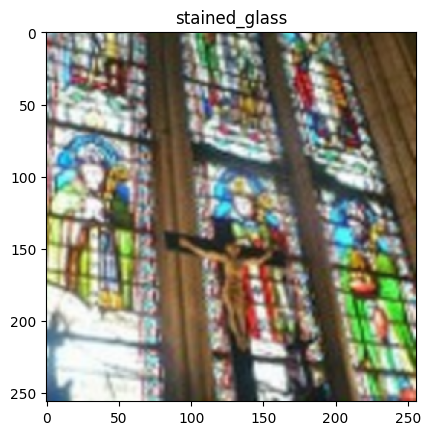

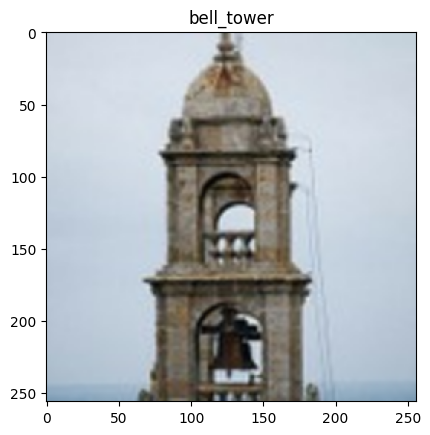

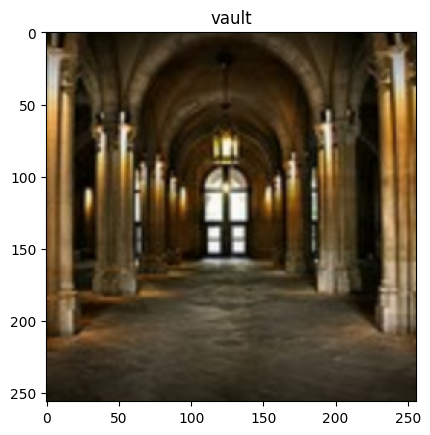

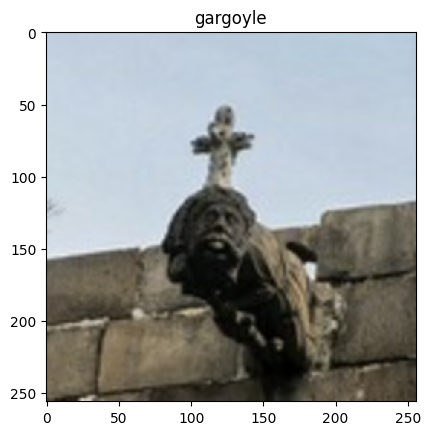

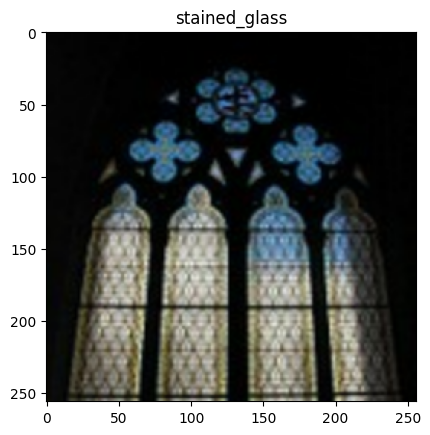

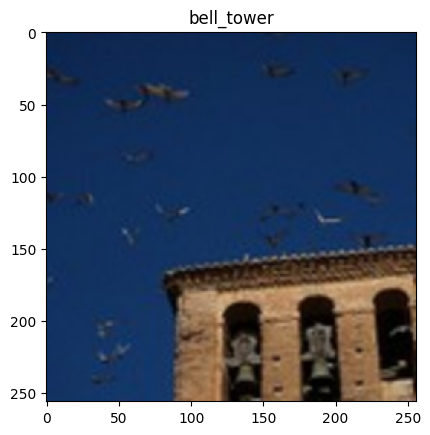

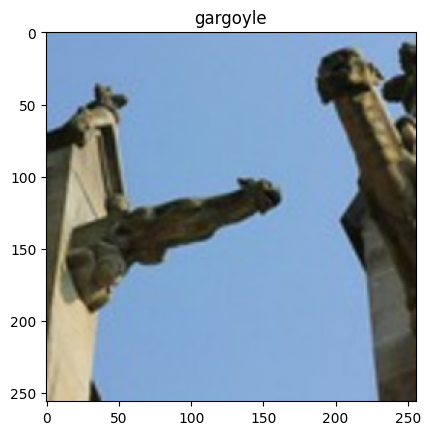

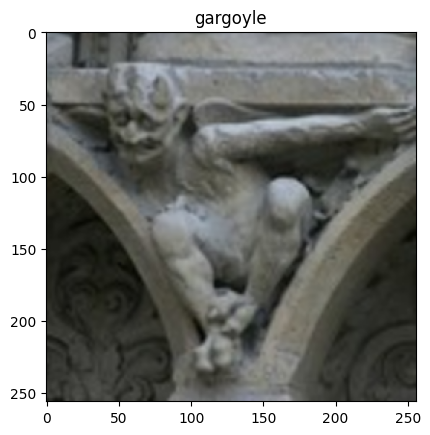

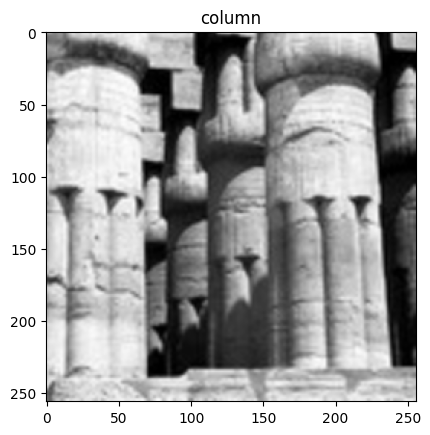

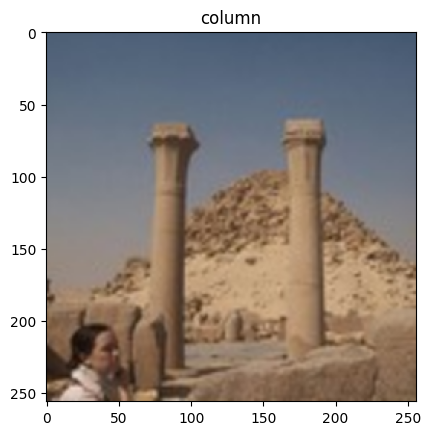

2024-10-28 20:51:32.581476: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(batch_size):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.show()

### 4. Preprocess the Data for Use in the ML Model

In [4]:
from tensorflow.keras.utils import to_categorical

def preprocess_labels(ds):
    def _preprocess(image, label):
        label = to_categorical(label, num_classes=11)
        return image, label
    return ds.map(_preprocess)

train_ds = preprocess_labels(train_ds)
val_ds = preprocess_labels(val_ds)

In [5]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### 5. Import and Customize a Pretrained CNN Model

In [6]:
from tensorflow.keras.applications import VGG16

input_layer = layers.Input(shape=(256, 256, 3))  # Define the input shape
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)
base_model.trainable = False
base_model_output = base_model.output
flat = layers.Flatten()(base_model_output)
dense1 = layers.Dense(128, activation='relu')(flat)
dense2 = layers.Dense(128, activation='relu')(dense1)
output = layers.Dense(11, activation='softmax')(dense2)

In [8]:
model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,927,051 (72.20 MB)

 Trainable params: 4,212,363 (16.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 6. Compile and Train the Model

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[callback])

Epoch 1/30


I0000 00:00:1730171102.733980   27458 service.cc:146] XLA service 0x7feac0004c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730171102.734281   27458 service.cc:154]   StreamExecutor device (0): Quadro T1000, Compute Capability 7.5
2024-10-28 20:05:03.121735: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 20:05:03.659377: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-28 20:05:09.086108: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-28 20:05:11.534022: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GP

Text(0.5, 1.0, 'Training and Validation Accuracy')

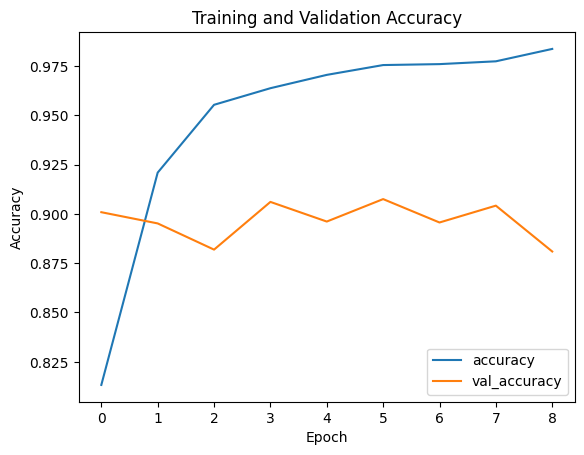

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### 7. Train the model on augmented data

In [7]:
new_input_layer = layers.Input(shape=(256, 256, 3))  # Define the input shape
augmentation1 = layers.RandomFlip("horizontal_and_vertical")(new_input_layer)
augmentation2 = layers.RandomRotation(0.2)(augmentation1)
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=augmentation2)
base_model.trainable = False
base_model_output = base_model.output
flat = layers.Flatten()(base_model_output)
dense1 = layers.Dense(128, activation='relu')(flat)
dense2 = layers.Dense(128, activation='relu')(dense1)
new_output = layers.Dense(11, activation='softmax')(dense2)

In [8]:
augmentation_model = Model(inputs=new_input_layer, outputs=new_output)
augmentation_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Due to repeated fluctuations in the validation accuracy during training sessions, the patience for the early stopping is set to 2. 

In [9]:
new_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

In [10]:
history2 = augmentation_model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[new_callback])

Epoch 1/30


2024-10-28 21:13:21.772933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730175201.903808   57129 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175201.983361   57129 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175202.025408   57129 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175202.065129   57129 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175202.105224   57129 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175202.143478   57129 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175202.187601   57129 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175202.196313   57129 gpu_t

843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6202 - loss: 1.2456

W0000 00:00:1730175442.018428   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.024612   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.029217   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.033662   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.038612   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.045287   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.049736   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.055905   57124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175442.063014   57124 gp

844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6203 - loss: 1.2452

W0000 00:00:1730175499.608117   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.613140   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.618490   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.624128   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.628899   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.637248   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.642600   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.647923   57127 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730175499.656178   57127 gp

844/844 ━━━━━━━━━━━━━━━━━━━━ 308s 351ms/step - accuracy: 0.6204 - loss: 1.2448 - val_accuracy: 0.8221 - val_loss: 0.5642
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 291s 344ms/step - accuracy: 0.7837 - loss: 0.6482 - val_accuracy: 0.8397 - val_loss: 0.5251
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 290s 344ms/step - accuracy: 0.8137 - loss: 0.5773 - val_accuracy: 0.8145 - val_loss: 0.5889
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 295s 350ms/step - accuracy: 0.8265 - loss: 0.5256 - val_accuracy: 0.8454 - val_loss: 0.5205
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 291s 344ms/step - accuracy: 0.8453 - loss: 0.4852 - val_accuracy: 0.8506 - val_loss: 0.4907
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 291s 344ms/step - accuracy: 0.8541 - loss: 0.4511 - val_accuracy: 0.8615 - val_loss: 0.4671
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 286s 339ms/step - accuracy: 0.8559 - loss: 0.4415 - val_accuracy: 0.8700 - val_loss: 0.4083
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 297s 352ms/step - accuracy: 0.8585 - loss: 0.44

Text(0.5, 1.0, 'Training and Validation Accuracy with Augmentation')

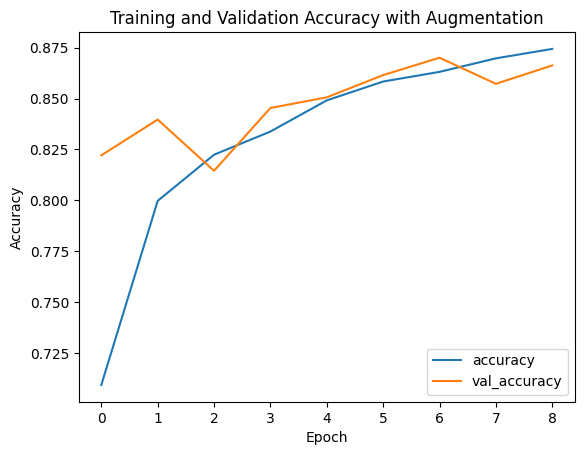

In [11]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with Augmentation')

With augmentation, the training and validation accuracy are much more closely correlated. It approaches the same accuracy as the non-augmented validation accuracy fluctuated around. They also stop after the same number of epochs.

The non-augmented model is much more overtrained early on and remains so. The augmented model does not suffer from overtraining to a significant degree.

Without early stopping, it appears the augmented model is starting to overfit and would continue to do so. 

## Part 2

### 1. Import, Inspect and Clean the Datasets

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df_tourism = pd.read_excel('tourism_with_id.xlsx')
df_user = pd.read_csv('user.csv')
df_tourism_rating = pd.read_csv('tourism_rating.csv')
df_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [15]:
df_user['Location'].unique()

array(['Semarang, Jawa Tengah', 'Bekasi, Jawa Barat',
       'Cirebon, Jawa Barat', 'Lampung, Sumatera Selatan',
       'Jakarta Utara, DKI Jakarta', 'Jakarta Selatan, DKI Jakarta',
       'Bandung, Jawa Barat', 'Surabaya, Jawa Timur', 'Yogyakarta, DIY',
       'Bogor, Jawa Barat', 'Depok, Jawa Barat',
       'Jakarta Pusat, DKI Jakarta', 'Jakarta Timur, DKI Jakarta',
       'Subang, Jawa Barat', 'Jakarta Barat, DKI Jakarta',
       'Palembang, Sumatera Selatan', 'Sragen, Jawa Tengah',
       'Ponorogo, Jawa Timur', 'Klaten, Jawa Tengah', 'Solo, Jawa Tengah',
       'Tanggerang, Banten', 'Serang, Banten', 'Cilacap, Jawa Tengah',
       'Kota Gede, DIY', 'Karawang, Jawa Barat', 'Purwakarat, Jawa Barat',
       'Nganjuk, Jawa Timur', 'Madura, Jawa Timur'], dtype=object)

In [16]:
df_tourism['City'].unique()

array(['Jakarta', 'Yogyakarta', 'Bandung', 'Semarang', 'Surabaya'],
      dtype=object)

In [17]:
df_user.drop_duplicates(subset='User_Id', keep='first', inplace=True)
df_user = df_user.dropna()
df_user.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [18]:
df_tourism.info()
# df_tourism.drop_duplicates(subset='Tourism_Id', keep='first', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [19]:
df_tourism = df_tourism.drop('Unnamed: 11', axis=1)
df_tourism = df_tourism.drop('Unnamed: 12', axis=1)
df_tourism['Time_Minutes'] = df_tourism['Time_Minutes'].fillna(df_tourism['Time_Minutes'].mean())

In [20]:
df_tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


### 2. Examine the Data for Trends and Highlights

#### A. Explore the user group

##### A. Analyze the age distribution of the users

<Axes: xlabel='Age', ylabel='Count'>

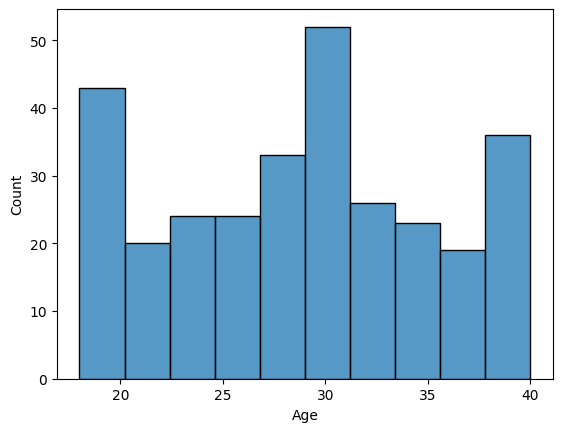

In [21]:
sns.histplot(df_user['Age'])

##### B. Identiry where most of the users are coming from

<Axes: xlabel='Location', ylabel='Count'>

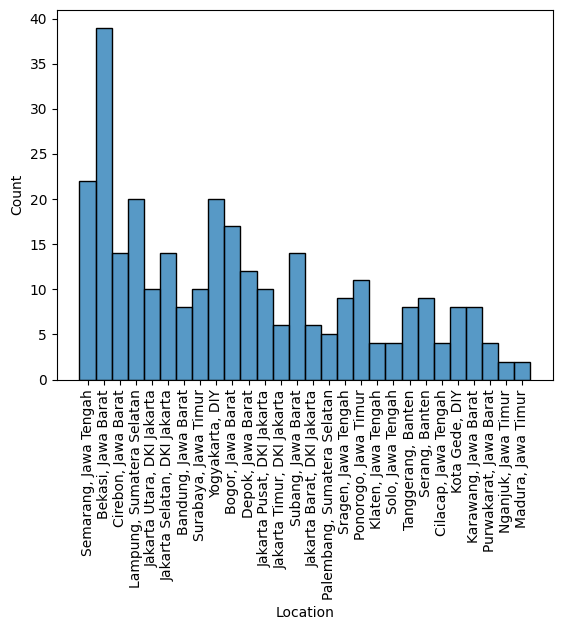

In [22]:
plt.xticks(rotation=90)
sns.histplot(df_user['Location'])

### 3. Explore the locations and categories of the tourist spots

##### A. What are the different categories of tourist spots?

In [23]:
df_tourism['Category'].value_counts()

Category
Taman Hiburan         135
Budaya                117
Cagar Alam            106
Bahari                 47
Tempat Ibadah          17
Pusat Perbelanjaan     15
Name: count, dtype: int64

##### B. What kind of tourism is each location most famous or suitable for?

In [24]:
grouped = df_tourism.groupby('City')['Category']
grouped.describe()

,count,unique,top,freq
City,,,,
Bandung,124,5,Cagar Alam,54
Jakarta,84,6,Budaya,32
Semarang,57,5,Cagar Alam,20
Surabaya,46,6,Taman Hiburan,18
Yogyakarta,126,5,Taman Hiburan,36


##### C. Which city would be best for a nature enthusiast to visit?

cagar alam = nature reserve 
taman hiburan = theme park  
budaya = culture    
tempet ibadah = place of worship    
Pusat Perbelanjaan = shopping center    

Each city has a unique concentration of tourism locations. And each one has a different category as its most suitable. 

A nature enthusiast would be best visiting Bandung. It has by far the highest concentration of nature reserves.


### 4. Create a combined data with places and their user ratings

In [25]:
df_tourism_with_rating = df_tourism.merge(df_tourism_rating, on='Place_Id', how='inner')
df_tourism_with_rating.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Place_Id       10000 non-null  int64  
 1   Place_Name     10000 non-null  object 
 2   Description    10000 non-null  object 
 3   Category       10000 non-null  object 
 4   City           10000 non-null  object 
 5   Price          10000 non-null  int64  
 6   Rating         10000 non-null  float64
 7   Time_Minutes   10000 non-null  float64
 8   Coordinate     10000 non-null  object 
 9   Lat            10000 non-null  float64
 10  Long           10000 non-null  float64
 11  User_Id        10000 non-null  int64  
 12  Place_Ratings  10000 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 1015.8+ KB


#### A. Use this to figure out the most loved spots by tourists. 

In [26]:
grouped = df_tourism_with_rating.groupby('Place_Name')['Rating'].agg('mean').sort_values(ascending=False)
grouped

Place_Name
Desa Wisata Sungai Code Jogja Kota    5.0
Wisata Kuliner Pecenongan             5.0
Freedom Library                       5.0
Kauman Pakualaman Yogyakarta          5.0
Kebun Tanaman Obat Sari Alam          4.9
                                     ... 
Desa Wisata Lembah Kalipancur         3.9
Curug Cipanas                         3.9
Tektona Waterpark                     3.8
Kampoeng Tulip                        3.8
Pantai Maron                          3.4
Name: Rating, Length: 437, dtype: float64

#### B. Which city has the most loved tourist spots?

In [27]:
grouped = df_tourism_with_rating.groupby('City')['Rating'].agg('mean').sort_values(ascending=False)
grouped

City
Jakarta       4.491302
Yogyakarta    4.466040
Surabaya      4.454190
Bandung       4.426742
Semarang      4.369021
Name: Rating, dtype: float64

#### C. Which category of attraction are users liking the most?

In [28]:
grouped = df_tourism_with_rating.groupby('Category')['Rating'].agg('mean').sort_values(ascending=False)
grouped

Category
Tempat Ibadah         4.715844
Budaya                4.523034
Pusat Perbelanjaan    4.457662
Cagar Alam            4.404058
Taman Hiburan         4.401965
Bahari                4.369694
Name: Rating, dtype: float64

### 5. Build a recommender model for the system

Use the above data to develop a collaborative filtering model for the recommendation and use that to recommend other places to visit using the current tourist location (place name)

This presents a unique challenge with the data given. The user 'Location' column does not necessarily correspond to the tourism 'City' column. There are 5 unique cities and 28 unique user locations. I see two ways of handling this.
1. By region.
    * Parse the user location and pick out the region. 
    * Associate one of the five major cities with each region.
    * Recommend the user places from that city.

2. By lat/long.
    * Get lat/long coordinates for each of the 28 unique User locations.
    * Use those coordinates to recommend similar locations sorted by distance.

Recommending by region risks running into edge cases where a user may be on the edge of one region and closer to a neighboring region's major city and attractions. 

Recommending by lat/long would be more arduous, but has the added benefit of similar lat/longs adding to the Pearson Correlation Coefficient during model building. As a result I'll be using this method.

I'll use the geopy library to extract lat/long from the location name.

In [29]:
from sklearn.decomposition import TruncatedSVD
from geopy.geocoders import Nominatim
import numpy as np

#### A. Generate Location Data

Loop through all the unique location names and make sure we can get actual locations for each one. 

In [30]:
geolocator = Nominatim(user_agent="IndonesiaCoordinates")
locations = df_user['Location'].unique().tolist()

latitudes = []
longitudes = []

for location in locations:
    location_obj = geolocator.geocode(location)
    if location_obj:
        latitudes.append(location_obj.latitude)
        longitudes.append(location_obj.longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)

print(latitudes)

[-6.9903988, -6.2349858, -6.7137044, -3.2069578, -6.136197, -6.28381815, -6.9215529, -7.2459717, -7.8011998, -6.5962986, -6.40719, -6.18233995, -6.26289085, -6.49838875, -6.161569, -2.9888243, -7.3924563, -7.97122665, -7.673189949999999, -7.5692489, -6.32990335, -6.032761, -7.46167105, None, -6.3021906, None, -7.600335, -7.0588909]


It seems some of the locations are returning none, because they're spelled incorrectly in the CSV. We will replace them with the correct spelling to be able to get actual location data.

In [31]:
df_user['Location'] = df_user['Location'].str.replace("Purwakarat, Jawa Barat", "Purwakarta, Jawa Barat")
df_user['Location'] = df_user['Location'].str.replace("Kota Gede, DIY", "Kotagede, DIY")

We'll now rerun the loop to get a complete list of coordinates. 

In [32]:
latitudes = []
longitudes = []

for location in locations:
    location_obj = geolocator.geocode(location)
    if location_obj:
        latitudes.append(location_obj.latitude)
        longitudes.append(location_obj.longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)

print(latitudes)

[-6.9903988, -6.2349858, -6.7137044, -3.2069578, -6.136197, -6.28381815, -6.9215529, -7.2459717, -7.8011998, -6.5962986, -6.40719, -6.18233995, -6.26289085, -6.49838875, -6.161569, -2.9888243, -7.3924563, -7.97122665, -7.673189949999999, -7.5692489, -6.32990335, -6.032761, -7.46167105, None, -6.3021906, None, -7.600335, -7.0588909]


Now we have actual location data for every unique place name.

Now we have 3 lists. 
* Location Name
* Latitude
* Longitude

We can now create 2 new columns to go in our user datafdrame. 1 for latitude, 1 for longitude. We'll create 2 dictionaries and map the lat/long to each unique value.

In [33]:
location_lats = dict(zip(locations, latitudes))
location_longs = dict(zip(locations, longitudes))

df_user['User_Lat'] = df_user['Location'].map(location_lats)
df_user['User_Long'] = df_user['Location'].map(location_longs)

df_user.head()


,User_Id,Location,Age,User_Lat,User_Long
0,1,"Semarang, Jawa Tengah",20,-6.990399,110.422910
1,2,"Bekasi, Jawa Barat",21,-6.234986,106.994544
2,3,"Cirebon, Jawa Barat",23,-6.713704,108.560848
3,4,"Bekasi, Jawa Barat",21,-6.234986,106.994544
4,5,"Lampung, Sumatera Selatan",20,-3.206958,104.649490


#### B. Create and Prepare the Utility Matrix

We want to create a similarity matrix first using all available locations so the model has maximum data to work with. 

In [34]:
df_combined = df_user.merge(df_tourism_rating.merge(df_tourism, on='Place_Id'), on='User_Id')
df_combined.head() 

,User_Id,Location,Age,User_Lat,User_Long,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:Í¶...,Budaya,Yogyakarta,75000,4.6,90.000000,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416
1,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,344,2,Pantai Marina,Pantai Marina (bahasa Jawa: Í¶•Í¶±Í¶∂Í¶±Í¶∂Í¶Ç...,Bahari,Semarang,3000,4.1,82.609756,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329
2,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.000000,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
3,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000,4.5,60.000000,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602
4,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,Yogyakarta,0,4.0,82.609756,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151


In [35]:
df_combined = df_combined.drop('Coordinate', axis=1)
df_combined.head()

,User_Id,Location,Age,User_Lat,User_Long,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Lat,Long
0,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:Í¶...,Budaya,Yogyakarta,75000,4.6,90.000000,-7.770542,110.489416
1,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,344,2,Pantai Marina,Pantai Marina (bahasa Jawa: Í¶•Í¶±Í¶∂Í¶±Í¶∂Í¶Ç...,Bahari,Semarang,3000,4.1,82.609756,-6.948877,110.389329
2,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.000000,-6.124190,106.839134
3,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000,4.5,60.000000,-7.264599,110.404602
4,1,"Semarang, Jawa Tengah",20,-6.990399,110.42291,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,Yogyakarta,0,4.0,82.609756,-7.792190,110.362151


Using the combined matrix, we can build a crosstab matrix of users, place names, and ratings.

In [36]:
rating_crosstab = df_combined.pivot_table(values='Place_Ratings', index='User_Id', columns='Place_Name', fill_value=0)
rating_crosstab.head()

Place_Name,Air Mancur Menari,Air Terjun Kali Pancur,Air Terjun Kedung Pedut,Air Terjun Semirang,Air Terjun Sri Gethuk,Alive Museum Ancol,Alun Alun Selatan Yogyakarta,Alun-Alun Kota Bandung,Alun-alun Utara Keraton Yogyakarta,Amazing Art World,...,Wisata Alam Wana Wisata Penggaron,Wisata Batu Kuda,Wisata Eling Bening,Wisata Kaliurang,Wisata Kampung Krisan Clapar,Wisata Kraton Jogja,Wisata Kuliner Pecenongan,Wisata Lereng Kelir,Wisata Mangrove Tapak,Wot Batu
User_Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we'll transpose the matrix to use it in SVD.

In [37]:
transposed_ratings = rating_crosstab.T
transposed_ratings.head()

User_Id,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
Place_Name,,,,,,,,,,,,,,,,,,,,,
Air Mancur Menari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Air Terjun Kali Pancur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
Air Terjun Kedung Pedut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Air Terjun Semirang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
Air Terjun Sri Gethuk,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### C. Decompose the Utility matrix and Create the Similarity Matrix

Using the transposed matrix, we'll run a Single Value Decomposition on it to reduce the dimensionality. 

In [38]:
SVD = TruncatedSVD(n_components=10, random_state = 42)
resultant_matrix = SVD.fit_transform(transposed_ratings)

Usine ght decomposed matrix, we'll get a correlation matrix using the Pearson's R correlation coefficient.

In [39]:
corr_matrix = np.corrcoef(resultant_matrix)

Now that we have a correlation for how similar each location is to every other location, we need to create a function to take a user id and do the following:

1. calculate a distance for every location from the user.
2. Sort the locations by distance and take the top X number of locations.
3. Take the user's highest rated location and get the similarity scores for the nearby locations.
4. Sort the locations by similarity and print the results.

#### D. Create the Recommendation Function

In [40]:
def RecommendNearbyLocations(user_id, number_of_locations):
    # Get user coordinates and a list of location coordinates to calculate distances
    user_coords = df_user.loc[user_id, ['User_Lat', 'User_Long']].values
    locations_coords = df_tourism[['Place_Name', 'Lat', 'Long']]

    # Get the ID and place name of the user's top rated place
    top_rated_place_id = df_tourism_rating[df_tourism_rating['User_Id'] == user_id].nlargest(5, 'Place_Ratings')['Place_Id'].values[0]
    top_rated_place = df_tourism[df_tourism['Place_Id'] == top_rated_place_id]['Place_Name'].values[0]

    # Calculate the distance from the user's location to each tourism location
    df_tourism['distance'] = np.sqrt((locations_coords['Lat'] - user_coords[0])**2 + (locations_coords['Long'] - user_coords[1])**2)

    # Get x number of the nearest locations dictated by number_of_locations
    nearby_locations = df_tourism.nsmallest(number_of_locations, 'distance')['Place_Name'].values

    # Get the column names in the rating_crosstab
    place_names = rating_crosstab.columns.tolist()

    # Get the column index of the top rated place and the nearby locations
    place_index = place_names.index(top_rated_place)

    # Get the column indexes of the nearby locations
    neaby_indexes = []
    for location in nearby_locations:
        neaby_indexes.append(place_names.index(location))

    # Get the column of the correlations to the user's top place
    corr_top_place = corr_matrix[place_index]

    # Get the correlations of nearby locations to that top place
    nearby_correlations = []
    for index in neaby_indexes:
        nearby_correlations.append(corr_top_place[index])

    # Group the place names and their correlations together and sort by highest correlation
    correlated_locations = dict(zip(nearby_locations, nearby_correlations))
    sorted_locations = sorted(correlated_locations.items(), key=lambda x: x[1], reverse=True)
    
    # Print the sorted place names
    for location in sorted_locations:
        print(location[0])

The function now returns nearby locations similar to one of the selected user's top rated destinations. Let's run it to see what we get out. 

In [41]:
RecommendNearbyLocations(20, 5)

Kampung Pelangi
Lawang Sewu
Pura Giri Natha
Taman Pandanaran
Indonesia Kaya Park
